In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        dummy = torch.zeros(img_shape).unsqueeze_(0)
        flatten_size = self.cnn_stack(dummy).shape[1]
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def cnn_stack(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.cnn_stack(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        return self.fc2(x)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

dataset_train = datasets.MNIST(
    "./data/mnist", train=True, download=True, transform=transform
)

dataset_test = datasets.MNIST("./data/mnist", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1000, shuffle=False)

Current Device:  cuda


In [4]:
print("Train Loader Check:")
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, y.dtype: {y.dtype}")
    break

print("\nTest Loader Check:")
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, y.dtype: {y.dtype}")
    break

Train Loader Check:
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), y.dtype: torch.int64

Test Loader Check:
Shape of X [N, C, H, W]: torch.Size([1000, 1, 28, 28])
Shape of y: torch.Size([1000]), y.dtype: torch.int64


In [5]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.2)
scheduler = StepLR(optimizer, step_size=7, gamma=0.8)
loss_fn = nn.CrossEntropyLoss()

In [6]:


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

hist_acc = [] 
hist_loss = [] 

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    hist_acc.append(100*correct)
    hist_loss.append(test_loss)

In [7]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    scheduler.step()

print("Done!")

Epoch 1
-------------------------------
loss: 2.294153  [    0/60000]
loss: 0.453215  [ 6400/60000]
loss: 0.195876  [12800/60000]
loss: 0.191784  [19200/60000]
loss: 0.171460  [25600/60000]
loss: 0.095549  [32000/60000]
loss: 0.154990  [38400/60000]
loss: 0.178587  [44800/60000]
loss: 0.113856  [51200/60000]
loss: 0.053584  [57600/60000]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.064504 

Epoch 2
-------------------------------
loss: 0.053738  [    0/60000]
loss: 0.066420  [ 6400/60000]
loss: 0.091849  [12800/60000]
loss: 0.045133  [19200/60000]
loss: 0.047552  [25600/60000]
loss: 0.061703  [32000/60000]
loss: 0.050644  [38400/60000]
loss: 0.041733  [44800/60000]
loss: 0.064465  [51200/60000]
loss: 0.192080  [57600/60000]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.047246 

Epoch 3
-------------------------------
loss: 0.028009  [    0/60000]
loss: 0.075597  [ 6400/60000]
loss: 0.072408  [12800/60000]
loss: 0.018589  [19200/60000]
loss: 0.036599  [25600/60000]
loss: 0.060528  [32000/600

In [11]:
hist_acc = [h/100 for h in hist_acc]

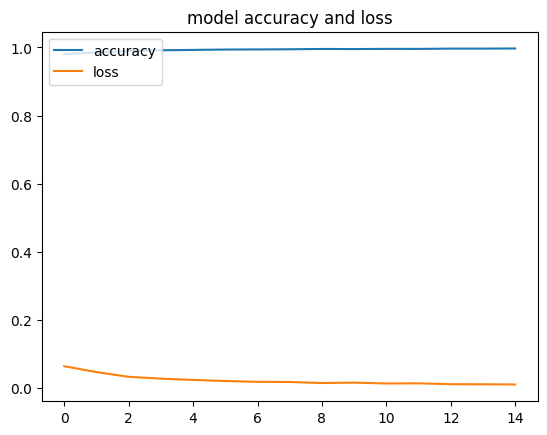

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist_acc)
plt.plot(hist_loss)
plt.title('model accuracy and loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()